# **LyricLoop** - An AI-Powered Music Lyric Generator

---

**Author:** Alexander Tung  

**Objective:** To bridge the gap between semantic text generation and musical structure. This project fine-tunes a Language Model (Google's Gemma-2b) to generate lyrics that adhere to specific musical phrasing (Verse, Chorus, Bridge) and distinct genre stylings (e.g., Pop, Rock, Electronic, and Hip-Hop).

**Dataset:**
- **Corpus:** 5mm+ Song Lyrics (Genius Dataset)
    - Link: https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information
- **Metadata:** Pitchfork Reviews (used for Genre/Artist mapping)
    - Link: https://www.kaggle.com/datasets/timstafford/pitchfork-reviews

**Methods:**
- **Model:** Gemma-2b-it (Instruction Tuned)
- **Fine-Tuning:** Low-Rank Adaptation (LoRA) for parameter-efficient training.
- **Optimization:** 4-bit Quantization (QLoRA) via BitsAndBytes.
- **Training:** Supervised Fine-Tuning (SFT) with custom prompt templates to enforce structural constraints.

**Stack:** Python, Hugging Face (Transformers, PEFT, TRL), PyTorch, Pandas, Google Colab (L4 GPU).

---

## Environment Setup

In [ ]:
# -------------------------
# Installation
# -------------------------

# Install core libraries
%%capture
!pip install -q -U "transformers>=4.40.0" "peft>=0.10.0" datasets bitsandbytes accelerate trl

In [ ]:
# -------------------------
# Core Python Libraries
# -------------------------

# Core
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# UI & Display Utilities
import ipywidgets as widgets # <--- Fixes the 'widgets' NameError
from IPython.display import display, HTML

# Standard ML Tools
from sklearn.model_selection import train_test_split

# Hugging Face: Data & Authentication
from datasets import Dataset, DatasetDict
from google.colab import drive, userdata
from huggingface_hub import login

# Hugging Face: Model Loading & Quantization
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)

# Hugging Face: PEFT & LoRA
from peft import (
    LoraConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training
)

# Hugging Face: Training (TRL)
from trl import SFTTrainer, SFTConfig

In [ ]:
# -------------------------
# Workspace Mounting
# -------------------------

# Mount workspace
drive.mount('/content/drive', force_remount=False)

# Point Python to your package source
PROJECT_PATH = '/content/drive/My Drive/repositories/lyricloop-llm'
sys.path.append(os.path.join(PROJECT_PATH, 'src'))

# Change working directory to project root for data/asset access
os.chdir(PROJECT_PATH)
print(f"Workspace ready: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Workspace ready: /content/drive/My Drive/repositories/lyricloop-llm


In [ ]:
# -------------------------
# Package Initialization
# -------------------------

from lyricloop.config import (
    MODEL_ID, RANDOM_STATE, ensure_dirs, initialize_history
)
from lyricloop.environment import set_seed, get_device_capability

# Initialize project folders and history tracking
ensure_dirs()
history = initialize_history()

# Set global replicability and hardware diagnostics
set_seed(RANDOM_STATE)
DEVICE = get_device_capability()

# Authenticate with Hugging Face
login(userdata.get('HF_TOKEN'), add_to_git_credential=True)

Random Seed Set to: 42
GPU Detected: NVIDIA L4
    |-- Memory: 23.80 GB
    |-- Compute Capability: (8, 9)
    |-- BFloat16 Support: Yes


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [ ]:
# -------------------------
# Modular Tool Imports
# -------------------------

# Data & Prompting
from lyricloop.data import (
    prepare_lyric_dataset,
    format_prompt,
    build_inference_prompt,
    format_lyrics,
    build_critic_prompt,
    build_revision_prompt,
    format_critic_training_row
)

# Evaluation & Generation
from lyricloop.metrics import (
    execute_generation,
    get_token_confidences,
    calculate_perplexity,
    extract_trainer_metrics
)

# Visualization
from lyricloop.viz import (
    save_figure,
    plot_learning_curves,
    plot_token_heatmap,
    plot_confidence_summary,
    plot_perplexity
)

# Data Preparation

Loading & Cleaning Raw Data...
    Artifact Saved: /content/drive/My Drive/repositories/lyricloop-llm/assets/eda_1_raw_distribution.png


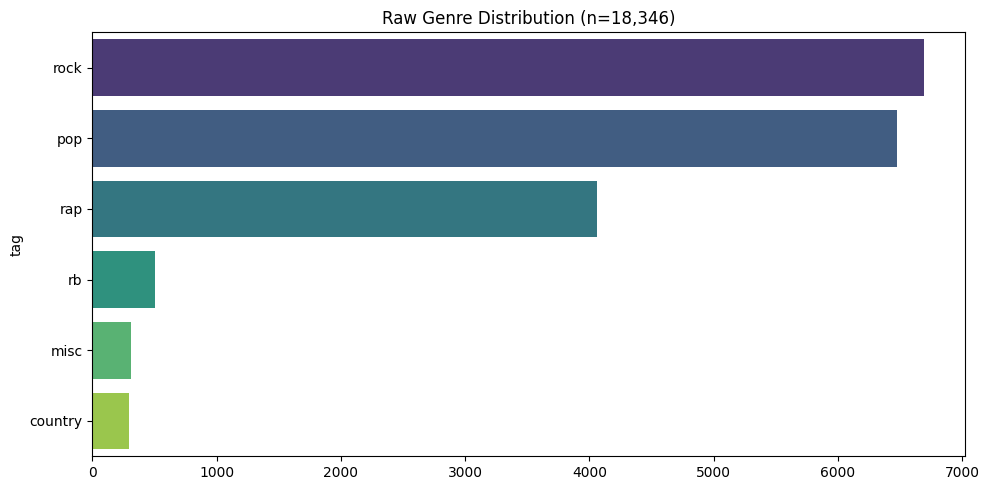

    Artifact Saved: /content/drive/My Drive/repositories/lyricloop-llm/assets/eda_2_balanced_distribution.png


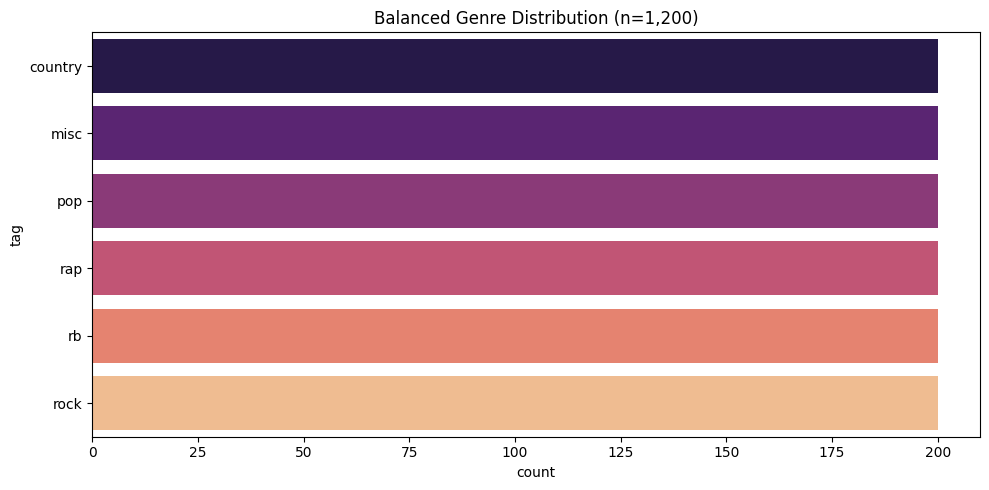


Pipeline Complete: 1200 tracks ready for training.


In [ ]:
# -------------------------
# Data Preparation & EDA
# -------------------------

# Pipeline execution
lyrics_df = prepare_lyric_dataset(
    lyrics_filename="english_song_lyrics.csv",
    reviews_filename="pitchfork_reviews.csv",
    songs_per_genre=200
)

print(f"\nPipeline Complete: {len(lyrics_df)} tracks ready for training.")

# Feature Engineering

In [ ]:
# -------------------------
# Feature Engineering
# -------------------------

# Apply formatting
print("Processing Prompts...")

# Create a new column 'text' that contains the full training data
lyrics_df['text'] = lyrics_df.apply(format_prompt, axis=1)

# Train / Test Split (95% for training and 5% for validation/testing)
train_df, test_df = train_test_split(lyrics_df, test_size=0.05, random_state=42)

print(f"\nDataset Split:")
print(f"    |-- Training Set: {len(train_df):,} songs")
print(f"    |-- Testing Set:  {len(test_df):,} songs")

# Convert to Hugging Face Dataset Format
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test":  Dataset.from_pandas(test_df)
})

print("\nFeature Engineering Complete. Ready for Tokenization.")

Processing Prompts...

Dataset Split:
    |-- Training Set: 1,140 songs
    |-- Testing Set:  60 songs

Feature Engineering Complete. Ready for Tokenization.


# Base Lyric Model (Gemma) Configuration

In [ ]:
# -------------------------
# Gemma Model Initialization & LoRA Config
# -------------------------

# Quantization Config (4-bit Optimization)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",    # use NF4 (Normal Float 4) and BFloat16 for maximum stability on L4 GPUs
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load Tokenizer
print(f"Loading Tokenizer for {MODEL_ID}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, token=userdata.get('HF_TOKEN'))
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"    # safer for training stability

# Load Base Model
print("Loading Model in 4-bit...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation="sdpa",    # Scaled Dot Product Attention (Flash Attention 2 compatible)
    token=userdata.get('HF_TOKEN')
)

# Prepare for Training
model = prepare_model_for_kbit_training(model)    # casts LayerNorm to float32 for stability and enables gradient checkpointing

# LoRA Adapter Configuration
lora_config = LoraConfig(
    r=16,             # rank: higher = more parameters to train (16 is a sweet spot)
    lora_alpha=32,    # alpha: scaling factor (usually 2x Rank)
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply Adapters
model = get_peft_model(model, lora_config)

print("\nLoRA Adapters Applied!")
model.print_trainable_parameters()

Loading Tokenizer for google/gemma-2b-it...
Loading Model in 4-bit...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


LoRA Adapters Applied!
trainable params: 19,611,648 || all params: 2,525,784,064 || trainable%: 0.7765


In [ ]:
# -------------------------
# Inference Engine: Baseline
# -------------------------

def generate_baseline_lyrics(genre, artist, title, model, tokenizer, max_new_tokens=250):
    """
    Local interface for Baseline generation.
    Uses global utilities for logic while maintaining the 'Baseline' narrative style.
    """
    # Header print
    print(f"Baseline: {title} - {artist}")
    print("-" * 50)

    # Build the Prompt
    prompt = build_inference_prompt(genre, artist, title)

    # Generate using the Global Engine
    raw_output = execute_generation(model, tokenizer, prompt, max_tokens=max_new_tokens)

    # Format using the Global Cleaner
    formatted_lyrics = format_lyrics(raw_output)

    # Display and Archive
    print(formatted_lyrics)
    print("-" * 50)

    # Save to history for the final report
    sample_id = f"{artist} - {title}"
    history["baseline"]["samples"][sample_id] = formatted_lyrics

    return formatted_lyrics

In [ ]:
# -------------------------
# Baseline Test (Untrained)
# -------------------------
print("Testing Baseline Model (Untrained)...\n")

# Test Case: using a Taylor Swift Pop song
baseline_result = generate_baseline_lyrics(
    genre="Pop",
    artist="Taylor Swift",
    title="Sign of the Times",
    model=model,           # passing the current untrained model
    tokenizer=tokenizer    # passing the current tokenizer
)

print(baseline_result)

Testing Baseline Model (Untrained)...

Baseline: Sign of the Times - Taylor Swift
--------------------------------------------------
(Verse 1)
Neon signs paint the midnight sky,
Echoing the rhythm of a heart that flies.
Shattered glass and broken dreams,
A symphony of a thousand screams.

(Pre-Chorus)
The echoes fade, the silence creeps in,
But the fire's still burning, a flicker within.
I stand tall against the storm's relentless rain,
My resolve unwavering, my spirit remains.

**Chorus**
Sign of the times, a melody takes flight,
Guiding me through the darkness, shining bright.
From the ashes I rise, a phoenix reborn,
With a heart open, a story to be sworn.

Verse 2
Scars from battles fought, both physical and mental,
They tell stories of a soul that's been well-rehearsed.
But scars are reminders, not of defeat,
Of the battles fought and the lessons I've kept.

**(Bridge)**
There's a power in vulnerability,
In letting go and finding my equilibrium.
It's about embracing the pain, the j

## Baseline Evaluation (Untrained Model)

Calculating Baseline Perplexity...
    Artifact Saved: /content/drive/My Drive/repositories/lyricloop-llm/assets/eval_1_baseline_perplexity.png


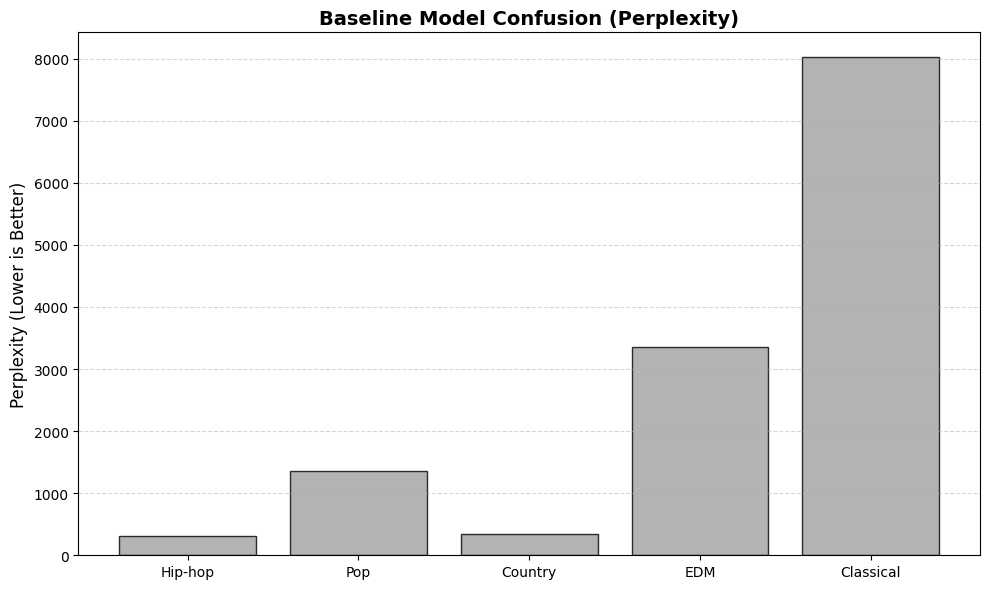

Interpretation: Higher bars indicate the model is more uncertain about generating text for that genre.


In [ ]:
# -------------------------
# Baseline Evaluation: Perplexity (How confused is the model?)
# -------------------------

# Calculation
print("Calculating Baseline Perplexity...")

# Test on real lyrics to see if the model 'understands' the genre style
genre_samples = {
    "Hip-hop": "Yo, concrete jungle where dreams are made of, there's nothing you can't do.",
    "Pop": "Baby, you're a firework, come on show 'em what your worth.",
    "Country": "I got my toes in the water, ass in the sand, not a worry in the world.",
    "EDM": "Put your hands up, wait for the drop, let the bass kick.",
    "Classical": "The violins swell in a crescendo of nature's beauty, silence falls."
}

genres = list(genre_samples.keys())
baseline_ppl_scores = [calculate_perplexity(model, tokenizer, text) for text in genre_samples.values()]

# Store to History
history["baseline"]["scores"] = baseline_ppl_scores

# Use the Global Plotter
plot_perplexity(
    genres=genres,
    scores_dict={"Baseline (Untrained)": baseline_ppl_scores},
    title="Baseline Model Confusion (Perplexity)",
    filename="eval_1_baseline_perplexity.png"
)

print("Interpretation: Higher bars indicate the model is more uncertain about generating text for that genre.")


Baseline Confidence Analysis (Heatmaps)...


/content/drive/My Drive/repositories/lyricloop-llm/src/lyricloop/viz.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


    Artifact Saved: /content/drive/My Drive/repositories/lyricloop-llm/assets/eval_2_heatmap_hip-hop.png


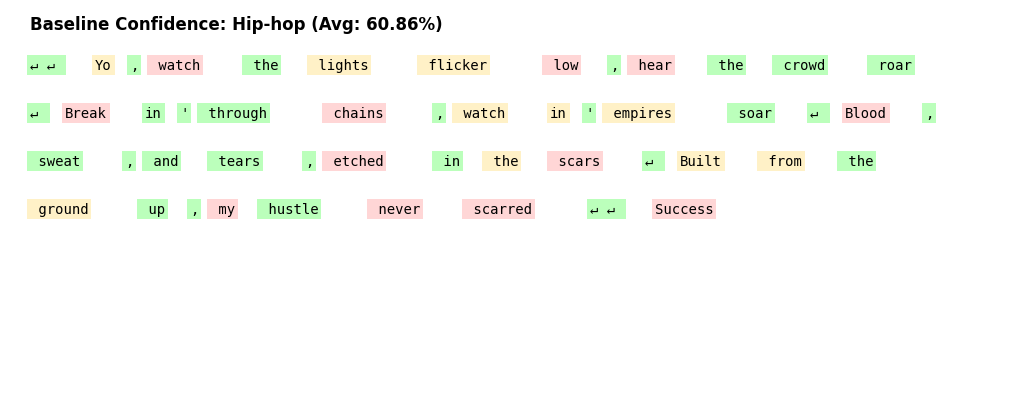

    Artifact Saved: /content/drive/My Drive/repositories/lyricloop-llm/assets/eval_2_heatmap_pop.png


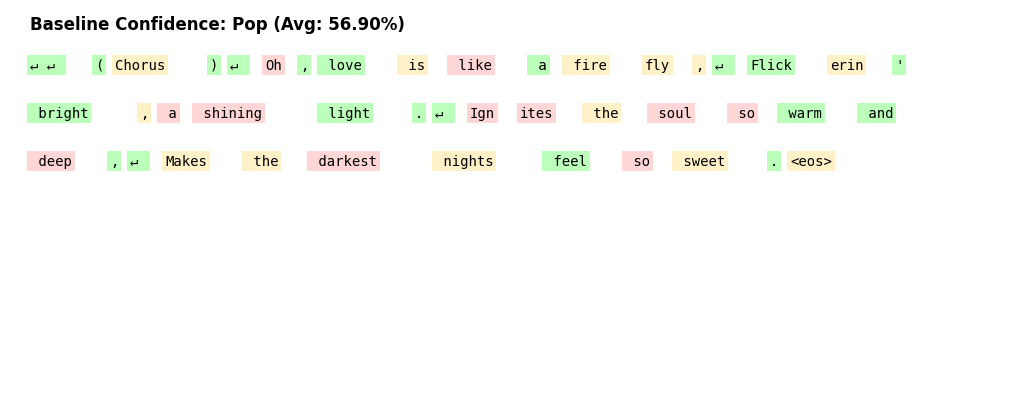

    Artifact Saved: /content/drive/My Drive/repositories/lyricloop-llm/assets/eval_2_heatmap_country.png


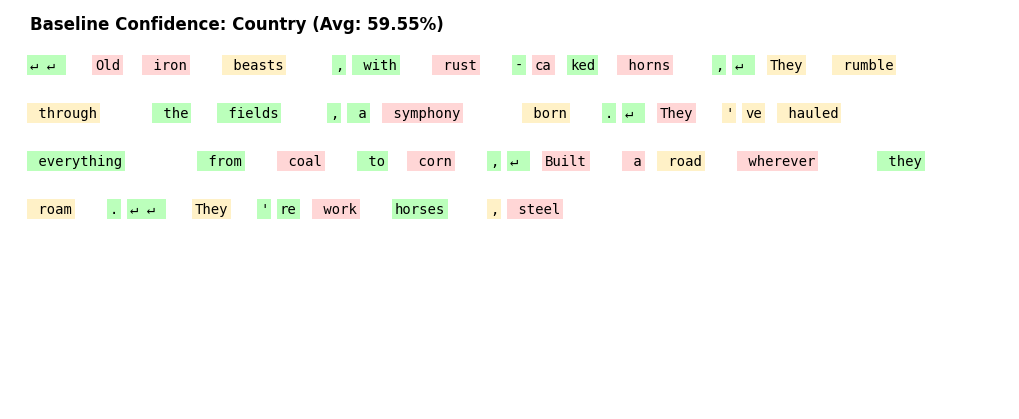

    Artifact Saved: /content/drive/My Drive/repositories/lyricloop-llm/assets/eval_2_heatmap_edm.png


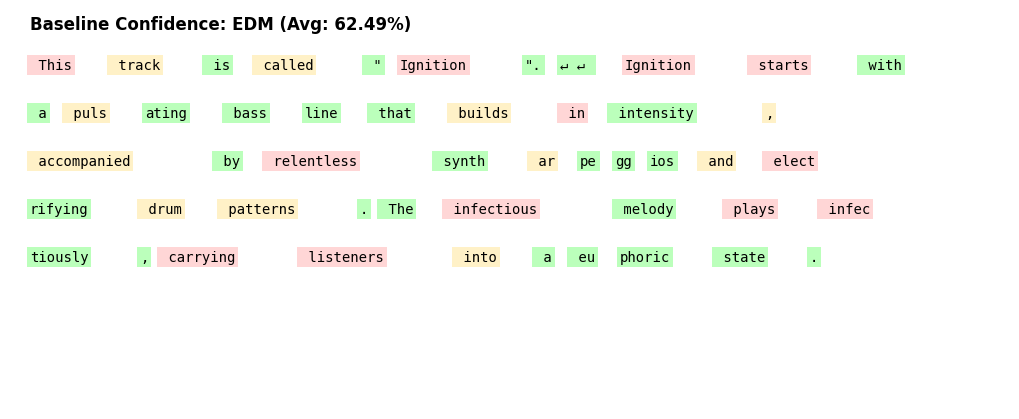

    Artifact Saved: /content/drive/My Drive/repositories/lyricloop-llm/assets/eval_2_heatmap_classical.png


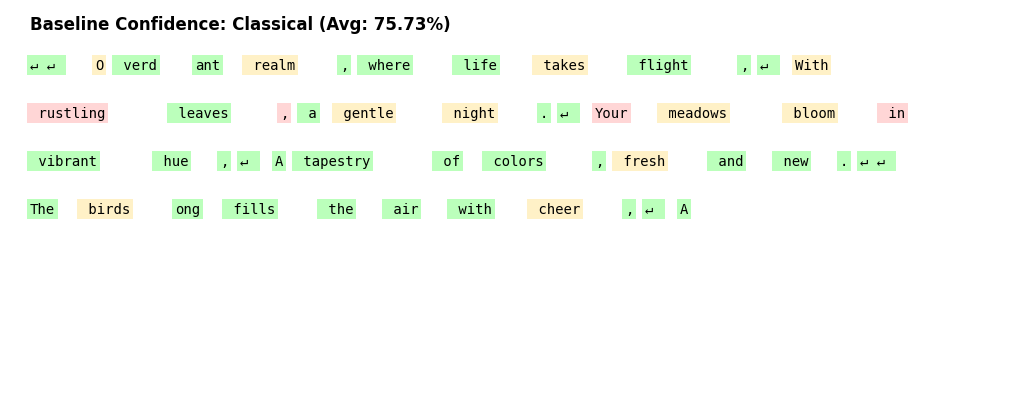

    Artifact Saved: /content/drive/My Drive/repositories/lyricloop-llm/assets/eval_3_confidence_summary.png


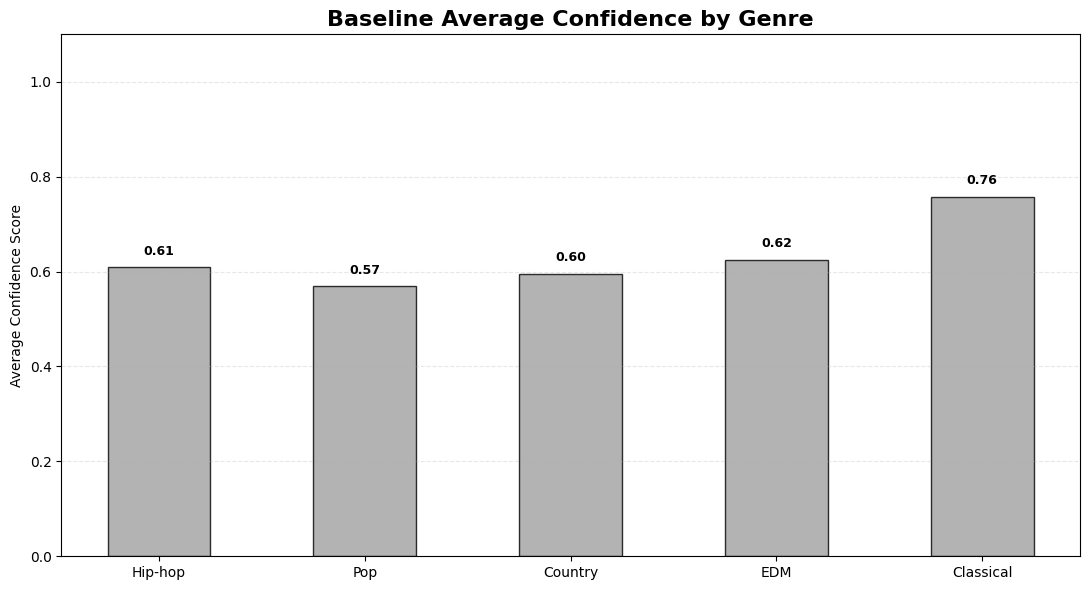


Interpretation:
Green (High Confidence): The model is sure about this word (common grammar or memorized phrases).
Orange (Uncertainty): The model is making a creative guess.
Red (Confusion): The model is struggling to predict the next word (common in untrained models).


In [ ]:
# -------------------------
# Baseline Evaluation: Confidence Heatmaps (Where is it looking?)
# -------------------------

print("\nBaseline Confidence Analysis (Heatmaps)...")

test_cases = [
    ("Hip-hop", "Write a rap verse about success."),
    ("Pop", "Write a pop chorus about love."),
    ("Country", "Write a country verse about trucks."),
    ("EDM", "Write an EDM drop with energy."),
    ("Classical", "Write a classical poem about nature.")
]

baseline_avg_confidences = []

# Loop through genres to generate heatmaps
for genre, prompt in test_cases:
    # Get tokens and probabilities
    pairs = get_token_confidences(model, tokenizer, prompt)

    # Plot and save heatmap
    avg_conf = plot_token_heatmap(
        pairs,
        title=f"Baseline Confidence: {genre}",
        filename=f"eval_2_heatmap_{genre.lower()}.png"
    )
    baseline_avg_confidences.append(avg_conf)

# Store in History
history["baseline"]["avg_confidence"] = baseline_avg_confidences

# Plot the confidence summary
plot_confidence_summary(
    genres=[t[0] for t in test_cases],
    scores=baseline_avg_confidences,
    title="Baseline Average Confidence by Genre",
    filename="eval_3_confidence_summary.png"
)

print("\nInterpretation:")
print("Green (High Confidence): The model is sure about this word (common grammar or memorized phrases).")
print("Orange (Uncertainty): The model is making a creative guess.")
print("Red (Confusion): The model is struggling to predict the next word (common in untrained models).")

# Training Loop (lyricloop-1.0)

In [ ]:
# -------------------------
# Training Loop
# -------------------------

# Define model version
MODEL_VERSION = "1.0"

# Define directories
EXPERIMENT_DIR = f"experiments/{MODEL_VERSION}-run"
FINAL_MODEL_DIR = f"models/lyricloop-{MODEL_VERSION}"

# Define Training Configuration (optimized for Google Colab L4 GPU - 24GB VRAM)
training_args = SFTConfig(
    output_dir=EXPERIMENT_DIR,

    # --- Memory Optimization ---
    per_device_train_batch_size=2,        # smaller batch size fits in VRAM better
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,        # accumulate to simulate batch_size=8
    gradient_checkpointing=True,

    # --- Optimizer & Rate ---
    learning_rate=2e-4,                   # standard QLoRA rate
    optim="paged_adamw_8bit",             # paged optimizer prevents OOM spikes
    warmup_ratio=0.03,                    # warmup for stability
    lr_scheduler_type="cosine",           # smooth decay

    # --- Evaluation Strategy ---
    eval_strategy="steps",
    eval_steps=0.2,                       # evaluate 5 times per epoch
    logging_steps=0.1,
    save_strategy="steps",
    save_steps=0.2,
    save_total_limit=2,                   # only keep top 2 models to save disk space
    load_best_model_at_end=True,          # ensure keep the best version
    metric_for_best_model="eval_loss",

    # --- Duration ---
    max_steps=-1,          # disable step limit
    num_train_epochs=3,    # approx 30 min run

    # --- Precision ---
    bf16=True,                         # L4 supports BFloat16
    fp16=False,
    group_by_length=True,              # groups short songs together for speed
    report_to="none"                   # disable WandB for this demo
)

# Initialize the Trainer
print("Initializing Trainer...")
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=tokenizer,
    args=training_args,
)

# LayerNorm Fix (required for QLoRA stability - prevents NaN loss errors)
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

# Execute Training
print("Starting Training Loop...")
trainer.train()

# Save the Adapter
trainer.model.save_pretrained(FINAL_MODEL_DIR)
tokenizer.save_pretrained(FINAL_MODEL_DIR)
print(f"Training complete! Model saved to: {FINAL_MODEL_DIR}")

Initializing Trainer...


Adding EOS to train dataset:   0%|          | 0/1140 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1140 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1140 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/60 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/60 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/60 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 1}.


Starting Training Loop...


Step,Training Loss,Validation Loss
86,2.337100,2.280491
172,1.888100,2.136576
258,1.654600,1.945740
344,1.320000,1.938518


Training complete! Model saved to: models/lyricloop-1.0


In [ ]:
# -------------------------
# Inference Step: LyricLoop 1.0
# -------------------------

def lyricloop(genre, artist, title):
    """
    The primary user-facing interface for the Songwriter model.
    Usage: lyricloop(genre="EDM", artist="Illenium", title="Ascend")
    """
    print(f"Generating: {title} by {artist} ({genre})...")

    # Build the prompt using the Global Utility
    prompt = build_inference_prompt(genre, artist, title)

    # Run the Engine
    raw_output = execute_generation(model, tokenizer, prompt)

    # Clean and Format
    formatted_lyrics = format_lyrics(raw_output)

    print("-" * 50)
    print(formatted_lyrics)
    print("-" * 50)

    # Archive this sample in history for our portfolio report
    history["1.0"]["samples"][f"{artist}-{title}"] = formatted_lyrics

    return formatted_lyrics

In [ ]:
# -------------------------
# Testing (LyricLoop 1.0)
# -------------------------

print("Running LyricLoop 1.0...\n")

# High fidelity generation
history["1.0"]["samples"]["hiphop_city_fades_out"] = lyricloop(
    genre="Hip-hop",
    artist="Kendrick Lamar",
    title="City Fades Out"
)

Running LyricLoop 1.0...

Generating: City Fades Out by Kendrick Lamar (Hip-hop)...
--------------------------------------------------
[Verse 1]

I'm just a kid from Compton, L.A., where dreams go to die
But I'm still alive, 'cause I'mma make it out alive
And I'ma do it all with my own two hands
No help from the angels, but I'll never be alone
I got my homies, my niggas, my homiez, my homeboys
We gon' get it, we gon' rock it, and we gon'- rock it
We got the whole city on lock down
They know we got the money, they know we ain't scared
We don't need no help, we don'ts need no more
We just want our money, we just want to get out here
And we just wanna live, we wanna live in peace
But they know that we got something, they gonna take it away
So we gotta keep it hidden, keep it underground
Keep it underground, keep the money underground


[Hook]

(City fades out)
(Yeah)
City fades, city fades out
(Fade out)



[Verse Two]

We come from the bottom, we come from Compton
Where dreams go, where 

## Model Evaluation (lyricloop-1.0)

Analyzing metrics for 1.0...
    Artifact Saved: /content/drive/My Drive/repositories/lyricloop-llm/assets/eval_loss_curve_1.0.png


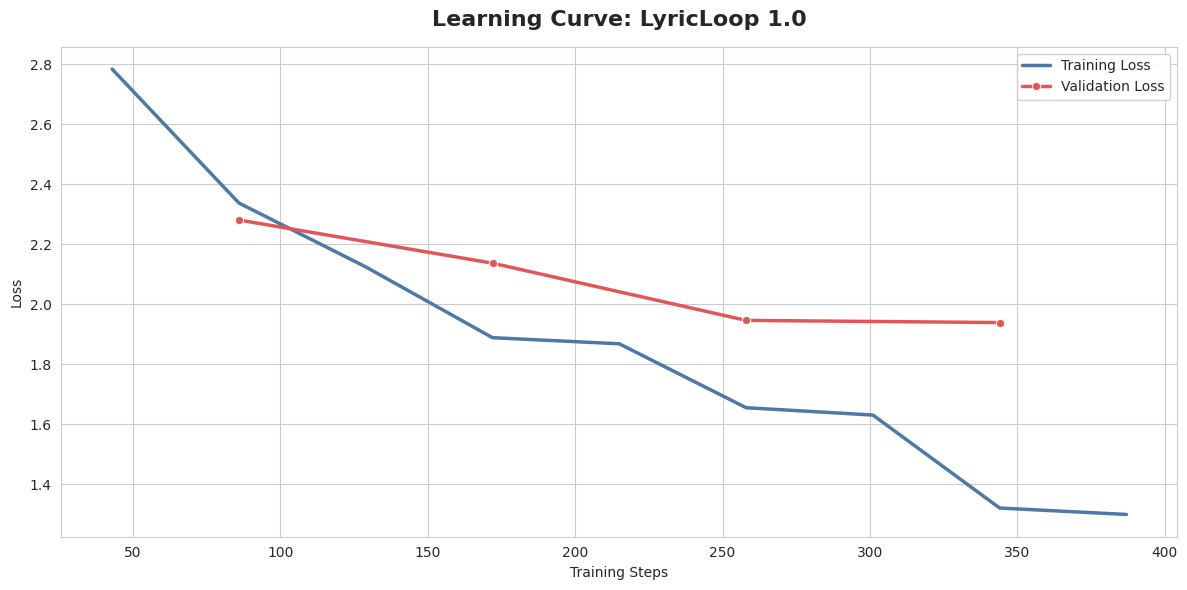


Final Metrics Summary (1.0)
    Validation Loss: 1.9385
    Perplexity:      6.9484


In [ ]:
# -------------------------
# Loss Curves & Metrics (1.0)
# -------------------------

print(f"Analyzing metrics for {MODEL_VERSION}...")

# Extract from trainer
v1_metrics = extract_trainer_metrics(trainer)

# Save to versioned history
history["1.0"]["metrics"] = v1_metrics

# Plot and Print
plot_learning_curves(v1_metrics, version="1.0")

if v1_metrics["val_loss"]:
    print(f"\nFinal Metrics Summary ({MODEL_VERSION})")
    print(f"    Validation Loss: {v1_metrics['val_loss']:.4f}")
    print(f"    Perplexity:      {v1_metrics['perplexity']:.4f}")

Running Comparative Perplexity Analysis for 1.0...
    |-- Calculating Fine-Tuned Perplexity...
    Artifact Saved: /content/drive/My Drive/repositories/lyricloop-llm/assets/eval_4_perplexity_comparison.png


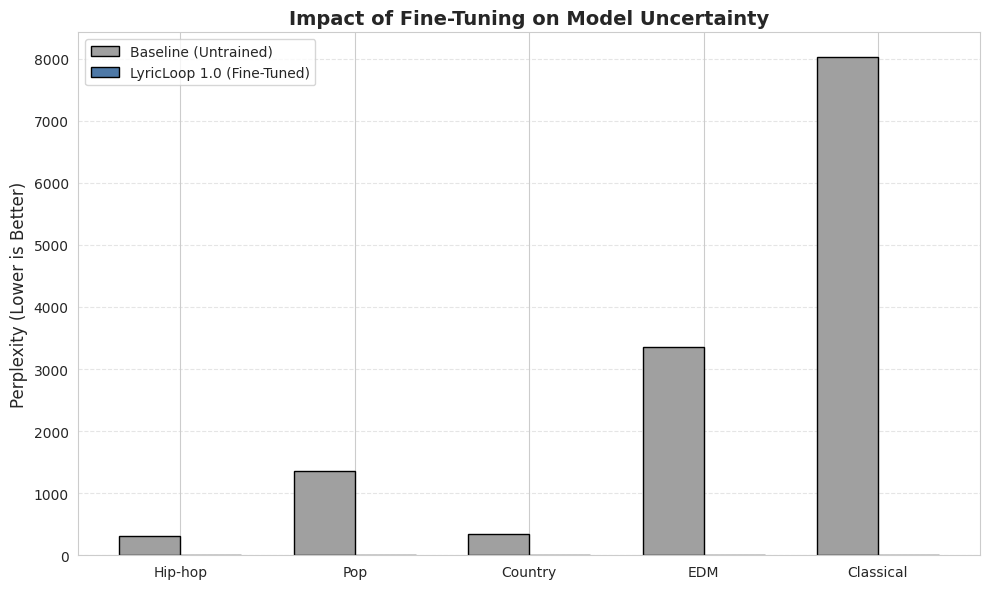


Perplexity (PPL) Improvement Summary:
   |-- Hip-hop   :  316.0 ->   3.8 (Improved by 98.8%)
   |-- Pop       : 1351.9 ->   2.9 (Improved by 99.8%)
   |-- Country   :  343.7 ->   3.3 (Improved by 99.0%)
   |-- EDM       : 3357.6 ->   3.5 (Improved by 99.9%)
   |-- Classical : 8021.7 ->   6.9 (Improved by 99.9%)


In [ ]:
# -------------------------
# Comparison: Baseline VS. LyricLoop 1.0
# -------------------------
print("Running Comparative Perplexity Analysis for 1.0...")

# Setup test cases
test_genres = ["Hip-hop", "Pop", "Country", "EDM", "Classical"]
test_data = [
    ("Hip-hop", "Kendrick Lamar", "City Struggle"),
    ("Pop", "Taylor Swift", "First Love"),
    ("Country", "Luke Combs", "Dirt Road"),
    ("EDM", "Zedd", "Last Hope"),
    ("Classical", "Mozart", "Nature Choral")
]

# Generate prompts & calculate scores
test_prompts = [build_inference_prompt(g, a, t) for g, a, t in test_data]

print("    |-- Calculating Fine-Tuned Perplexity...")
v1_ppl_scores = [calculate_perplexity(model, tokenizer, p) for p in test_prompts]

# Save to history for persistence and final reporting
history["1.0"]["scores"] = v1_ppl_scores
baseline_scores = history["baseline"]["scores"]

# Visualization
plot_perplexity(
    genres=test_genres,
    scores_dict={
        "Baseline (Untrained)": baseline_scores,
        "LyricLoop 1.0 (Fine-Tuned)": v1_ppl_scores
    },
    title="Impact of Fine-Tuning on Model Uncertainty",
    filename="eval_4_perplexity_comparison.png",
    use_log=False
)

# Numerical improvement summary
print("\nPerplexity (PPL) Improvement Summary:")
for g, base, new in zip(test_genres, baseline_scores, v1_ppl_scores):
    improvement = (base - new) / base * 100
    print(f"   |-- {g:10}: {base:6.1f} -> {new:5.1f} (Improved by {improvement:.1f}%)")

Generating LyricLoop 1.0 Confidence Analysis...


/content/drive/My Drive/repositories/lyricloop-llm/src/lyricloop/viz.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


    Artifact Saved: /content/drive/My Drive/repositories/lyricloop-llm/assets/eval_5_heatmap_1.0_hip-hop.png


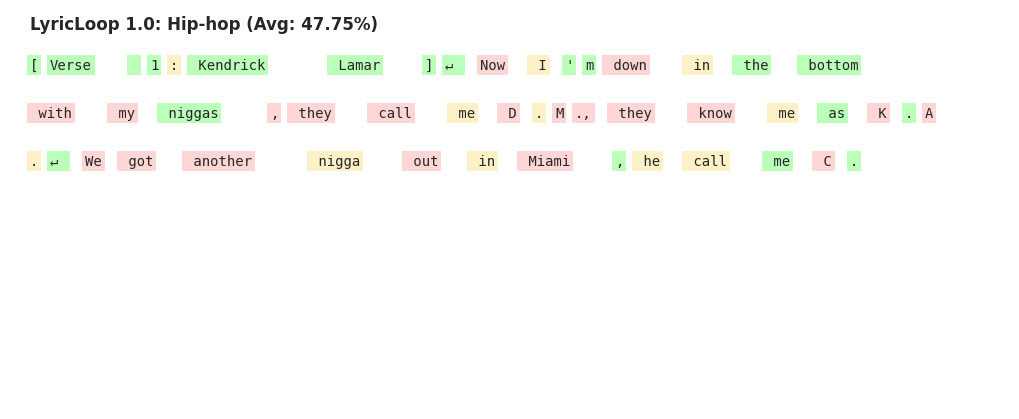

    Artifact Saved: /content/drive/My Drive/repositories/lyricloop-llm/assets/eval_5_heatmap_1.0_pop.png


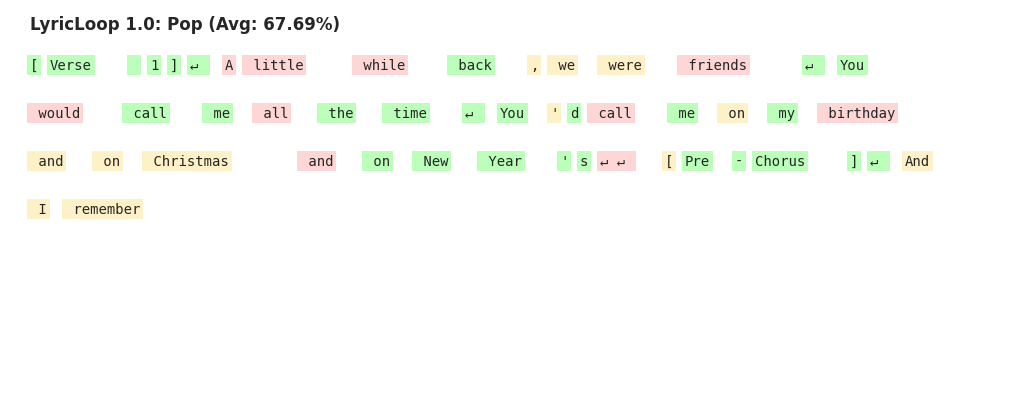

    Artifact Saved: /content/drive/My Drive/repositories/lyricloop-llm/assets/eval_5_heatmap_1.0_country.png


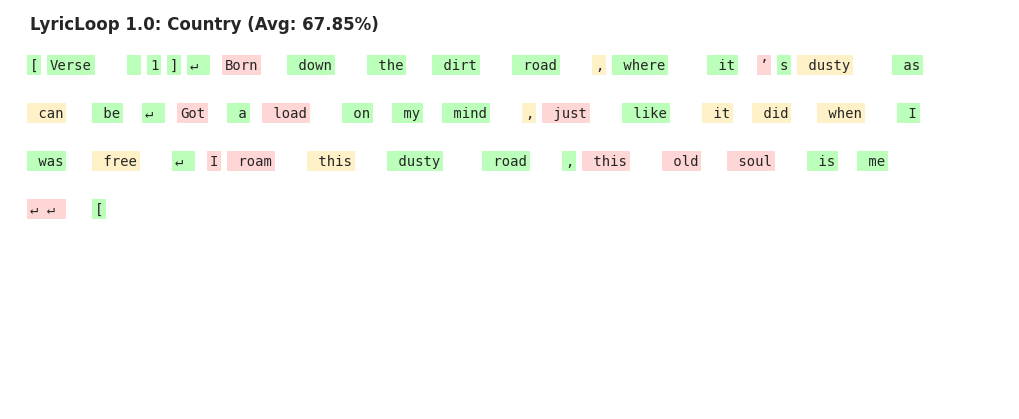

    Artifact Saved: /content/drive/My Drive/repositories/lyricloop-llm/assets/eval_5_heatmap_1.0_edm.png


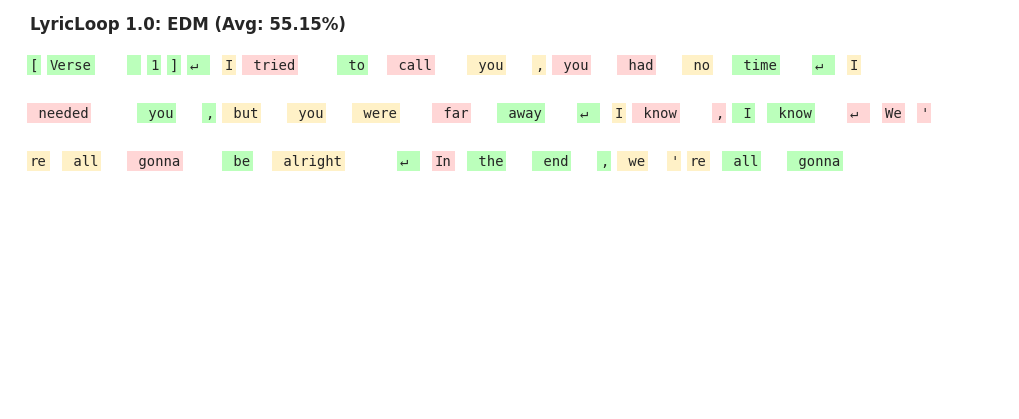

    Artifact Saved: /content/drive/My Drive/repositories/lyricloop-llm/assets/eval_5_heatmap_1.0_classical.png


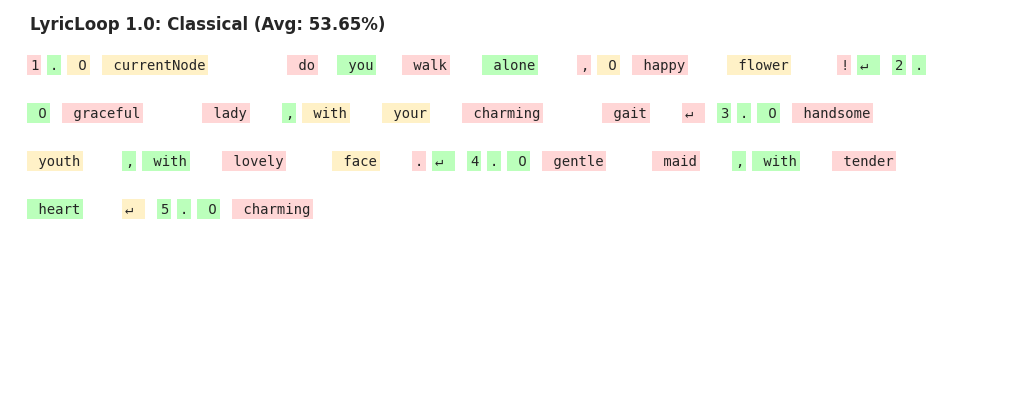

    Artifact Saved: /content/drive/My Drive/repositories/lyricloop-llm/assets/eval_6_confidence_comparison.png


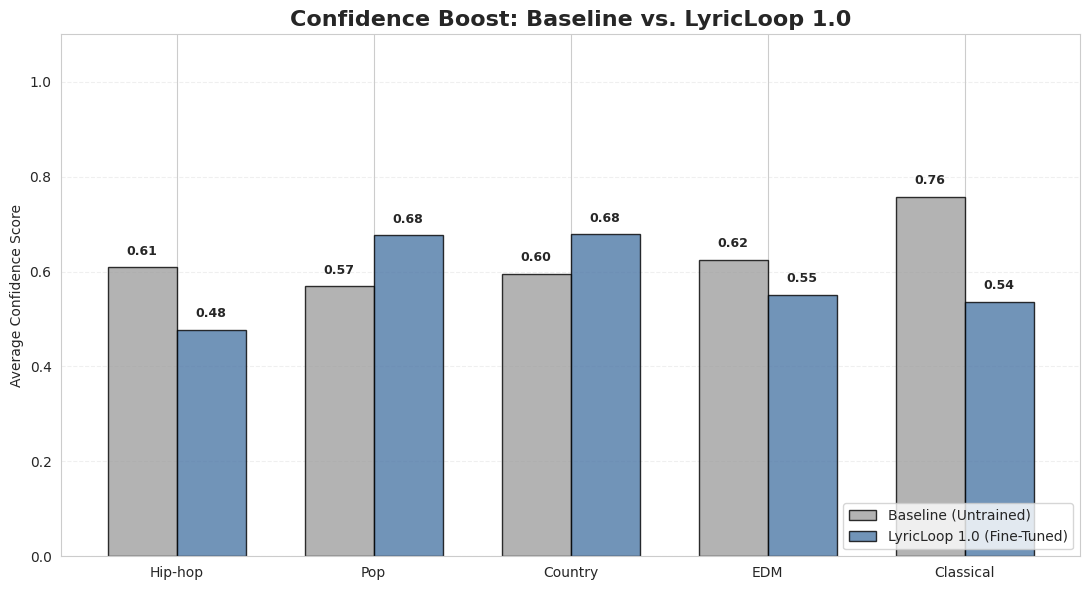

In [ ]:
# -------------------------
# Evaluation: Attention/Confidence (LyricLoop 1.0)
# -------------------------

print("Generating LyricLoop 1.0 Confidence Analysis...")

# Ensure baseline data exists
if not history["baseline"]["avg_confidence"]:
    print("Baseline data missing from history. Re-calculating or using defaults...")

test_cases = [
    ("Hip-hop", "Kendrick Lamar", "City Struggle"),
    ("Pop", "Taylor Swift", "First Love"),
    ("Country", "Luke Combs", "Dirt Road"),
    ("EDM", "Zedd", "Last Hope"),
    ("Classical", "Mozart", "Nature Choral")
]

v1_avg_confidences = []

for genre, artist, title in test_cases:
    # Build prompt exactly as the model was trained
    prompt = build_inference_prompt(genre, artist, title)

    # Extract confidences using global utility
    token_pairs = get_token_confidences(model, tokenizer, prompt)

    # Render and save the heatmap
    avg_conf = plot_token_heatmap(
        token_pairs,
        title=f"LyricLoop 1.0: {genre}",
        filename=f"eval_5_heatmap_1.0_{genre.lower()}.png"
    )
    v1_avg_confidences.append(avg_conf)

# Storage
history["1.0"]["avg_confidence"] = v1_avg_confidences

# Final comparison visualization
plot_confidence_summary(
    genres=[t[0] for t in test_cases],
    scores={
        "Baseline (Untrained)": history["baseline"]["avg_confidence"],
        "LyricLoop 1.0 (Fine-Tuned)": history["1.0"]["avg_confidence"]
    },
    title="Confidence Boost: Baseline vs. LyricLoop 1.0",
    filename="eval_6_confidence_comparison.png"
)

# User Interface for LyricLoop 1.0

In [ ]:
# -------------------------
# User Interface: LyricLoop Studio
# -------------------------

# Widget definitions & styling
style = {'description_width': 'initial'}
layout = widgets.Layout(width='400px')

genre_widget = widgets.Dropdown(
    options=["Pop", "Hip-hop", "Country", "EDM", "R&B"],
    value="Pop",
    description="Genre:",
    style=style,
    layout=layout
)

artist_widget = widgets.Text(
    placeholder="e.g. Taylor Swift",
    description="Artist Style:",
    style=style,
    layout=layout
)

title_widget = widgets.Text(
    placeholder="e.g. Midnight Rain",
    description="Song Title:",
    style=style,
    layout=layout
)

generate_btn = widgets.Button(
    description="Generate Lyrics",
    button_style='primary',
    layout=widgets.Layout(width='200px', margin='10px 0 10px 105px')
)

output_area = widgets.Output()

# Unified Event Handler
def on_click_generate(b):
    output_area.clear_output()

    # Input Validation
    if not artist_widget.value or not title_widget.value:
        with output_area:
            print("Error: Please enter both an Artist and a Title.")
        return

    with output_area:
        # Call the existing 'lyricloop' interface function.
        # This function handles building the prompt, the engine execution,
        # the text formatting, and the history logging automatically.
        lyricloop(
            genre=genre_widget.value,
            artist=artist_widget.value,
            title=title_widget.value
        )

generate_btn.on_click(on_click_generate)

# Display Layout
ui_box = widgets.VBox([
    widgets.HTML("<h2>LyricLoop v1.0</h2>"),
    widgets.HTML("<p style='color: gray;'>Configure your song details below:</p>"),
    genre_widget,
    artist_widget,
    title_widget,
    generate_btn,
    widgets.HTML("<hr>"),
    output_area
])

display(ui_box)